Exercise 2.5 (programming) Design and conduct an experiment to demonstrate
the difficulties that sample-average methods have for nonstationary problems. Use a
modified version of the 10-armed testbed in which all the q∗(a) start out equal and
then take independent random walks (say by adding a normally distributed increment
with mean zero and standard deviation 0.01 to all the q∗(a) on each step). Prepare
plots like Figure 2.2 for an action-value method using sample averages, incrementally
computed, and another action-value method using a constant step-size parameter,
α = 0.1. Use ε = 0.1 and longer runs, say of 10,000 steps. 

In [85]:
import numpy as np

#bandit class
#calculating Q values and storing the calculated values in the class itself for convenience
class Bandit:
    def __init__(self,m,a):
        self.mean = m
        self.alpha = a
        self.g_reward_css = 0.0
        self.g_reward_sa = 0.0
        self.g_pulled = 0.
        self.e_reward_css = 0.0
        self.e_reward_sa = 0.0
        self.e_pulled = 0.
        
    def pull(self):
        return np.random.randn() + self.mean
    
    def random_walk(self,std):
        self.mean += std*np.random.randn()

    #change the sample average. doing a running average rather than storing total rewards seperately
    def e_avm_sample_average(self, reward):
        #have to do it this way since I'm pulling when not doing avm_sample_average
        self.e_pulled += 1
        self.e_rewards_sa = (self.e_reward_sa * (self.e_pulled - 1) + reward) / self.e_pulled
            
    #increment the average value method for constant step
    def e_avm_constant_step(self,reward):
        #qn1 = qn + a*(r - qn)
        self.e_reward_css = self.e_reward_css + self.alpha*(reward-self.e_reward_css)
        
    def g_avm_sample_average(self, reward):
        #have to do it this way since I'm pulling when not doing avm_sample_average
        self.g_pulled += 1
        self.g_rewards_sa = (self.g_reward_sa * (self.g_pulled - 1) + reward) / self.g_pulled
            
    #increment the average value method for constant step
    def g_avm_constant_step(self,reward):
        #qn1 = qn + a*(r - qn)
        self.g_reward_css = self.g_reward_css + self.alpha*(reward-self.g_reward_css)
        

#keep the running average for plotting    
def add_trial_to_average(n,trial,avg):
    if len(avg) == 0:
        for i in range(len(trial)):
            avg.append(trial[i])
    else:
        for i in range(len(trial)):
            avg[i] = (avg[i]*(n-1) + trial[i]) / n
    return avg
        
#run trials
#only doing average rewards for greedy and epsilon 0.1
#question may be asking for epsilon 0.01 and for optimal choice % plots too

#greedy
g_sa_avg = []
g_css_avg = []
g_sa_trial = []
g_css_trial = []
#epsilon
epsilon = 0.1
e_sa_avg = []
e_css_avg = []
e_sa_trial = []
e_css_trial = []

#run through t trial
for t in range(100):
    #initialize bandits
    bandit_holder = []
    for i in range(10):
        bandit_holder.append(Bandit(0.0,0.1))
    
    if t > 0:
        #print("asdf",g_sa_avg)
        g_sa_avg = add_trial_to_average(t,g_sa_trial,g_sa_avg)
        g_css_avg = add_trial_to_average(t,g_css_trial,g_css_avg)
        e_sa_avg = add_trial_to_average(t,e_sa_trial,e_sa_avg)
        e_css_avg = add_trial_to_average(t,e_css_trial,e_css_avg)
        #print("asdf",g_sa_avg)
    #clear for the next trial
    g_sa_trial = []
    g_css_trial = []
    e_sa_trial = []
    e_css_trial = []
    
    #each step i in the trial
    for i in range(10000):
        #walk the bandits
        for j in bandit_holder:
            j.random_walk(0.01)
        
        #greedy pull
        sa_pull_index = -19
        sa_pull_value = -1919
        sa_tie_indices = []
        css_pull_index = -19
        css_pull_value = -1919
        css_tie_indices = []
        for j in range(10):
            if bandit_holder[j].g_reward_sa > sa_pull_value:
                sa_pull_index = j
                sa_pull_value = bandit_holder[j].g_reward_sa
                sa_tie_indices = [] #clear tie-breakers
            elif bandit_holder[j].g_reward_sa == sa_pull_value:
                if len(sa_tie_indices) == 0:
                    #first time tie_breaker is found, add the current best index
                    sa_tie_indices.append(sa_pull_index)
                sa_tie_indices.append(j)
            
            if bandit_holder[j].g_reward_css > css_pull_value:
                css_pull_index = j
                css_pull_value = bandit_holder[j].g_reward_css
                css_tie_indices = [] #clear tie-breakers
            elif bandit_holder[j].g_reward_css == css_pull_value:
                if len(css_tie_indices) == 0:
                    #first time tie_breaker is found, add the current best index
                    css_tie_indices.append(css_pull_index)
                css_tie_indices.append(j)
        
        #pull the greedy sa bandit, if tiebraker then select randomly
        if len(sa_tie_indices) > 0:
            sa_pull_index = sa_tie_indices[np.random.randint(0,len(sa_tie_indices))]
        #do the pull
        sa_pull_value = bandit_holder[sa_pull_index].pull()
        #add the pull value to the trial
        g_sa_trial.append(sa_pull_value)
        #update the bandit with the rewards
        bandit_holder[sa_pull_index].g_avm_sample_average(sa_pull_value)
        
        #pull the greedy css banding. if tiebreaker then select randomly
        if len(css_tie_indices) > 0:
            css_pull_index = css_tie_indices[np.random.randint(0,len(css_tie_indices))]
        #do the pull
        css_pull_value = bandit_holder[css_pull_index].pull()
        #add the pull value to the trial
        g_css_trial.append(css_pull_value)
        #update the bandit with the rewards
        bandit_holder[css_pull_index].g_avm_constant_step(css_pull_value)
        
        #epsilon pull
        if np.random.rand() <= epsilon:

            #random index
            e_pull_index = np.random.randint(0,10)
            
            #do sa the pull
            sa_pull_value = bandit_holder[e_pull_index].pull()
            #add the pull value to the trial
            e_sa_trial.append(sa_pull_value)
            #update the bandit with the rewards
            bandit_holder[e_pull_index].e_avm_sample_average(sa_pull_value)

            #do css the pull
            css_pull_value = bandit_holder[e_pull_index].pull()
            #add the pull value to the trial
            e_css_trial.append(css_pull_value)
            #update the bandit with the rewards
            bandit_holder[e_pull_index].e_avm_constant_step(css_pull_value)
        else:
            #in hindsight, probably should have made a greedy function
            #greedy pull
            sa_pull_index = -19
            sa_pull_value = -1919
            sa_tie_indices = []
            css_pull_index = -19
            css_pull_value = -1919
            css_tie_indices = []
            for j in range(10):
                if bandit_holder[j].e_reward_sa > sa_pull_value:
                    sa_pull_index = j
                    sa_pull_value = bandit_holder[j].e_reward_sa
                    sa_tie_indices = [] #clear tie-breakers
                elif bandit_holder[j].e_reward_sa == sa_pull_value:
                    if len(sa_tie_indices) == 0:
                        #first time tie_breaker is found, add the current best index
                        sa_tie_indices.append(sa_pull_index)
                    sa_tie_indices.append(j)

                if bandit_holder[j].e_reward_css > css_pull_value:
                    css_pull_index = j
                    css_pull_value = bandit_holder[j].e_reward_css
                    css_tie_indices = [] #clear tie-breakers
                elif bandit_holder[j].e_reward_css == css_pull_value:
                    if len(css_tie_indices) == 0:
                        #first time tie_breaker is found, add the current best index
                        css_tie_indices.append(css_pull_index)
                    css_tie_indices.append(j)

            #pull the greedy sa bandit, if tiebraker then select randomly
            if len(sa_tie_indices) > 0:
                sa_pull_index = sa_tie_indices[np.random.randint(0,len(sa_tie_indices))]
            #do the pull
            sa_pull_value = bandit_holder[sa_pull_index].pull()
            #add the pull value to the trial
            e_sa_trial.append(sa_pull_value)
            #update the bandit with the rewards
            bandit_holder[sa_pull_index].e_avm_sample_average(sa_pull_value)

            #pull the greedy css banding. if tiebreaker then select randomly
            if len(css_tie_indices) > 0:
                css_pull_index = css_tie_indices[np.random.randint(0,len(css_tie_indices))]
            #do the pull
            css_pull_value = bandit_holder[css_pull_index].pull()
            #add the pull value to the trial
            e_css_trial.append(css_pull_value)
            #update the bandit with the rewards
            bandit_holder[css_pull_index].e_avm_constant_step(css_pull_value)

In [86]:
# g_sa_avg = []
# g_css_avg = []
# g_sa_trial = []
# g_css_trial = []
# #epsilon
# epsilon = 0.1
# e_sa_avg = []
# e_css_avg = []
# e_sa_trial = []
# e_css_trial = []

#print(g_sa_avg,g_css_avg,e_sa_avg,e_css_avg)
#print(e_sa_trial)
#print(g_sa_trial)

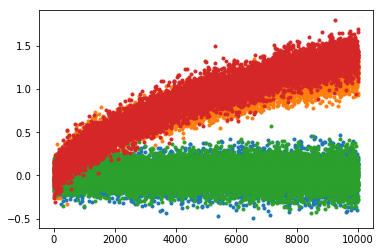

In [87]:
#css should outperform the sa plots
import matplotlib.pyplot as plt
plt.plot(g_sa_avg,'.') #blue
plt.plot(g_css_avg,'.') #orange
plt.plot(e_sa_avg,'.') #green
plt.plot(e_css_avg,'.') #red
plt.show()

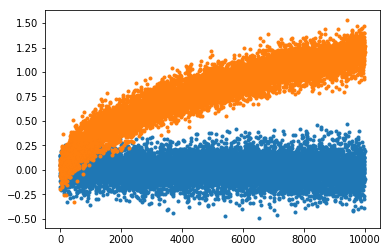

In [88]:
#import matplotlib.pyplot as plt
plt.plot(g_sa_avg,'.') #blue
plt.plot(g_css_avg,'.') #orange
#plt.plot(e_sa_avg,'.') #green
#plt.plot(e_css_avg,'.') #red
plt.show()

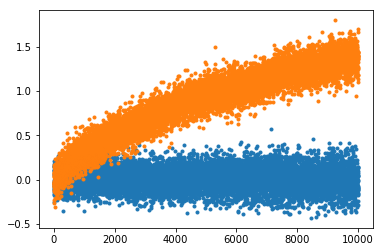

In [89]:
#plt.plot(g_sa_avg,'.') #blue
#plt.plot(g_css_avg,'.') #orange
plt.plot(e_sa_avg,'.') #green
plt.plot(e_css_avg,'.') #red
plt.show()

Exercise 2.8 (programming) Make a figure analogous to Figure 2.6 for the
non-stationary case outlined in Exercise 2.5. Include the constant-step-size ε-greedy
algorithm with α= 0.1. Use runs of 200,000 steps and, as a performance measure for
each algorithm and parameter setting, use the average reward over the last 100,000
steps. 

In [ ]:
#question is either asking for repeating the 4 algorithms in figure 2.6:
#need to implement algorithms for: 
#e-greedy with constant step size (done in 2.5)
#greedy with optimistic initialization (modify work done in 2.5)
#gradient bandit
#UCB

#or question is asking to redo 2.5 but allow parameters to be varied and then plot it
#would plot: 
#e-greedy css w/ alpha = 0.1 (vary epsilon)
#greedy sa (but no parameters but that is also simply a dot)
#greedy css (as alpha varies)
#e-greedy css (very alpha, assume epsilon is held at 0.1)
#e-greedy sa (vary epsilon)

#I think the question is asking for the latter
#the sa cases aren't very interesting as sa performs poorl for this
#so want:
#e-greedy css w/ alpha = 0.1 (vary epsilon)
#greedy css (as alpha varies)
#e-greedy css (very alpha, assume epsilon is held at 0.1)

#rough outline is
#run for 100,000 steps to 'train' each model
#run for another 100,000 and keep track of the average reward
#plot the average rewards
#thinking these values for the hyper parameters: 0.01,0.05,0.1,0.25,0.5

#components needed:
#modified bandit for the 3 cases
#initialize bandit with alpha and epsilon
#ie iterate over the hyperparameters
#store the running average for each in a dictionary with hyperparameters as keys

In [29]:
import numpy as np

#bandit class
#calculating Q values and storing the calculated values in the class itself for convenience
class Bandit:
    def __init__(self,m,a,e):
        self.mean = m
        self.alpha = a
        self.epsilon = e
        self.g_reward = 0.0
        self.e_fixed_reward = 0.0
        self.a_fixed_reward = 0.0
        
    def pull(self):
        return np.random.randn() + self.mean
    
    def random_walk(self,std):
        self.mean += std*np.random.randn()

        #increment the average value method for constant step
    def g_avm_constant_step(self,reward):
        #qn1 = qn + a*(r - qn)
        self.g_reward = self.g_reward + self.alpha*(reward-self.g_reward)
        
    def e_fixed(self,reward):
        #qn1 = qn + a*(r - qn)
        self.e_fixed_reward = self.e_fixed_reward + self.alpha*(reward-self.e_fixed_reward)
        
    def a_fixed(self,reward):  
        #qn1 = qn + 0.1*(r - qn)
        self.a_fixed_reward = self.a_fixed_reward + 0.1*(reward-self.a_fixed_reward)

#keep the running average for plotting    
def add_trial_to_average(n,trial,avg):
    if len(avg) == 0:
        for i in range(len(trial)):
            avg.append(trial[i])
    else:
        for i in range(len(trial)):
            avg[i] = (avg[i]*(n-1) + trial[i]) / n
    return avg

#hyper-parameter list
hyper_list = [0.01,0.05,0.1,0.25,0.5]
model_list = ["e_greedy_fixed_alpha","greedy","e_greedy_fixed_e"]

avg_value_dict = {}
for i in model_list:
    for j in hyper_list:
        z_string = i + "_" + str(j)
        avg_value_dict[z_string] = 0.0

n_steps = 200000

#looping through all the hyper parameters, averages are stored in a dictionary
for hyper_value in hyper_list:
    #initialize the bandits
    bandit_holder = []
    for i in range(10):
        bandit_holder.append(Bandit(0.0,hyper_value,0.1))
    #do the training
    for j in range(n_steps):
        for k in bandit_holder:
            k.random_walk(0.01)
            
        #find greedy choice
        #greedy always does greedy
        #randomize for fixed e choice
        #randomized for shaped e choice
        #update the choices internally in the bandit but don't need to keep track of rewards
        
        #reward order must be: ["e_greedy_fixed_alpha","greedy","e_greedy_fixed_e"]
        reward_list = []

        #fixed alpha, variable e pull
        g_pull_index = -19
        g_pull_value = -1919
        g_tie_indices = []
        
        if np.random.rand() < hyper_value:
            g_pull_index = np.random.randint(0,10)
        else:
            for k in range(10):
                if bandit_holder[k].a_fixed_reward > g_pull_value:
                    g_pull_index = k
                    g_pull_value = bandit_holder[k].a_fixed_reward
                    g_tie_indices = [] #clear tie-breakers
                elif bandit_holder[k].a_fixed_reward == g_pull_value:
                    if len(g_tie_indices) == 0:
                        #first time tie_breaker is found, add the current best index
                        g_tie_indices.append(g_pull_index)
                    g_tie_indices.append(k)
            
        if len(g_tie_indices) > 0:
            g_pull_index = g_tie_indices[np.random.randint(0,len(g_tie_indices))]
        #do the pull
        g_pull_value = bandit_holder[g_pull_index].pull()
        #add the pull value to the trial
        if j > n_steps / 2:
            reward_list.append(g_pull_value)
        #update the bandit with the rewards
        bandit_holder[g_pull_index].a_fixed(g_pull_value)   
        
        #greedy pull
        g_pull_index = -19
        g_pull_value = -1919
        g_tie_indices = []

        for k in range(10):
            if bandit_holder[k].g_reward > g_pull_value:
                g_pull_index = k
                g_pull_value = bandit_holder[k].g_reward
                g_tie_indices = [] #clear tie-breakers
            elif bandit_holder[k].g_reward == g_pull_value:
                if len(g_tie_indices) == 0:
                    #first time tie_breaker is found, add the current best index
                    g_tie_indices.append(g_pull_index)
                g_tie_indices.append(k)
    
        if len(g_tie_indices) > 0:
            g_pull_index = g_tie_indices[np.random.randint(0,len(g_tie_indices))]
        #do the pull
        g_pull_value = bandit_holder[g_pull_index].pull()
        #add the pull value to the trial
        if j > n_steps / 2:
            reward_list.append(g_pull_value)
        #update the bandit with the rewards
        bandit_holder[g_pull_index].g_avm_constant_step(g_pull_value)        
                

        #fixed e pull
        g_pull_index = -19
        g_pull_value = -1919
        g_tie_indices = []
        
        if np.random.rand() < bandit_holder[0].epsilon:
            g_pull_index = np.random.randint(0,10)
        else:
            for k in range(10):
                if bandit_holder[k].e_fixed_reward > g_pull_value:
                    g_pull_index = k
                    g_pull_value = bandit_holder[k].e_fixed_reward
                    g_tie_indices = [] #clear tie-breakers
                elif bandit_holder[k].e_fixed_reward == g_pull_value:
                    if len(g_tie_indices) == 0:
                        #first time tie_breaker is found, add the current best index
                        g_tie_indices.append(g_pull_index)
                    g_tie_indices.append(k)
            
        if len(g_tie_indices) > 0:
            g_pull_index = g_tie_indices[np.random.randint(0,len(g_tie_indices))]
        #do the pull
        g_pull_value = bandit_holder[g_pull_index].pull()
        #add the pull value to the trial
        if j > n_steps / 2:
            reward_list.append(g_pull_value)
        #update the bandit with the rewards
        bandit_holder[g_pull_index].e_fixed(g_pull_value)               

            
        if j > n_steps / 2: 
            #update avg values
            reward_steps = j - n_steps / 2
            for model_name, model_value in zip(model_list,reward_list):
                z_string = model_name + "_" + str(hyper_value)
                avg_value_dict[z_string] = (avg_value_dict[z_string] * (reward_steps-1) + model_value) / reward_steps

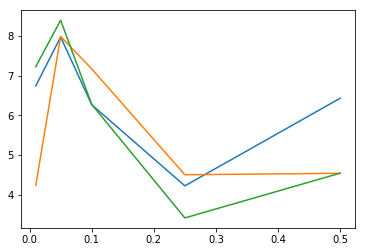

In [30]:
import matplotlib.pyplot as plt
e_greedy_fixed_e_plot = []
greedy_plot = []
e_greedy_fixed_alpha_plot = []

for i in hyper_list:
    z_string = model_list[0] + "_" + str(i)
    e_greedy_fixed_alpha_plot.append(avg_value_dict[z_string])
    z_string = model_list[1] + "_" + str(i)
    greedy_plot.append(avg_value_dict[z_string])
    z_string = model_list[2] + "_" + str(i)
    e_greedy_fixed_e_plot.append(avg_value_dict[z_string])
    
plt.plot(hyper_list,e_greedy_fixed_e_plot) #blue
plt.plot(hyper_list,greedy_plot) #orange
plt.plot(hyper_list,e_greedy_fixed_alpha_plot) #green
plt.show()